<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/17_17_RF__16_18_VISUALISATIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
from google.colab import drive
from google.colab import widgets
import os
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from rasterio.windows import Window
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from tqdm import tqdm
import time
import warnings


In [58]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:

zip_path = input("Please paste the path to your zip file from the sidebar: ")
destination = "/content/dataset"

if os.path.exists(zip_path):
    !unzip -q "{zip_path}" -d "{destination}"
    print(f"Successfully unzipped to {destination}")
else:
    print("Error: File path not found. Did you mount your drive?")
drive.mount('/content/drive')

KeyboardInterrupt: Interrupted by user

In [ ]:

S_RGB_PATH = input("Summer RGB Path: ")
S_NDVI_PATH = input("Summer NDVI Path: ")
S_DSM = input("Summer DSM Path: ")
W_RGB_PATH = input("Winter RGB Path: ")
W_NDVI_PATH = input("Winter NDVI Path: ")
W_DSM = input("Winter DSM Path: ")
SHP_PATH = input("Shapefile (.shp) Path: ")


In [61]:
import rasterio
import geopandas as gpd
import os

# Define your file paths in a dictionary for easy iteration
files = {
    "Summer RGB": "/content/dataset/scraghbog/scraghbog_rgb_summer.tif",
    "Summer NDVI": "/content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif",
    "Summer DSM": "/content/dataset/scraghbog/scraghbog_dem_summer.tif",
    "Winter RGB": "/content/dataset/scraghbog/Scraghbog_RGB_winter.tif",
    "Winter NDVI": "/content/dataset/scraghbog/Scraghbog_Winter_NDVI.tif",
    "Winter DSM": "/content/dataset/scraghbog/Scraghbog_Winter_DSM.tif"
}

shp_path = "/content/dataset/scraghbog/scraghBog_habiMap.shp"

print(f"{'Dataset':<15} | {'Resolution (x, y)':<25} | {'CRS'}")
print("-" * 60)

# Process Rasters
for name, path in files.items():
    if os.path.exists(path):
        with rasterio.open(path) as src:
            # res returns (x_resolution, y_resolution)
            res = src.res
            crs = src.crs.to_epsg() if src.crs else "Unknown"
            print(f"{name:<15} | {str(res):<25} | EPSG:{crs}")
    else:
        print(f"{name:<15} | File not found.")

# Process Shapefile
if os.path.exists(shp_path):
    gdf = gpd.read_file(shp_path)
    print(f"\nShapefile Bounds: {gdf.total_bounds}")
    print(f"Shapefile CRS: {gdf.crs}")

Dataset         | Resolution (x, y)         | CRS
------------------------------------------------------------
Summer RGB      | (0.029995299999999944, 0.02999529999999984) | EPSG:2157
Summer NDVI     | (0.04415057816729925, 0.044151543698846774) | EPSG:2157
Summer DSM      | (0.03489590000000139, 0.034895900000000445) | EPSG:2157
Winter RGB      | (0.03481329999999814, 0.03481329999999879) | EPSG:2157
Winter NDVI     | (0.06563180612056939, 0.06563050923390715) | EPSG:2157
Winter DSM      | (0.03481410000000176, 0.03481409999999858) | EPSG:2157

Shapefile Bounds: [641903.79713001 758404.7553     642876.3054     759768.0117    ]
Shapefile CRS: EPSG:2157


In [62]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import joblib
import warnings

warnings.filterwarnings('ignore')

In [63]:
# --- 1. SETTINGS & PATHS ---
# Based on your Winter NDVI (coarsest resolution)
TARGET_RES = 0.06563
# 20m / 0.06563m = ~305 pixels
KERNEL = int(20 / TARGET_RES)

In [64]:
fossitt_merger = {
    'GS4': 'Grassland',
    'PF1' : 'fen & flush',
    'PF3': 'bog',
    'WD4': 'Tree plantation',
    'WN6': 'willow',
    'WN7': 'bog woodland',
    'FS1': 'Swamp reeds',
    'FS2': 'Swamp',
    'FW2/WL2': 'water'
}

In [65]:


def get_16_features(win_data, res):
    """Calculates 16 features: RGB, NDVI, VARI, DSM, and Topography."""
    eps = 1e-7

    # 1-6. Summer & Winter RGB (Means)
    s_rgb = np.nanmean(win_data['s_rgb'], axis=(1, 2)).astype('float64')
    w_rgb = np.nanmean(win_data['w_rgb'], axis=(1, 2)).astype('float64')

    # 7-8. NDVI (Means)
    s_nd = np.clip(np.nanmean(win_data['s_ndvi']), -0.9, 0.9)
    w_nd = np.clip(np.nanmean(win_data['w_ndvi']), -0.9, 0.9)

    # 9-10. VARI Calculation: (G - R) / (G + R - B)
    def calc_vari(rgb):
        r, g, b = rgb[0], rgb[1], rgb[2]
        return (g - r) / (g + r - b + eps)

    s_vari = np.clip(calc_vari(s_rgb), -10, 10)
    w_vari = np.clip(calc_vari(w_rgb), -10, 10)

    # 12-13. DSM Height (Means)
    s_h = np.nanmean(win_data['s_dsm'])
    w_h = np.nanmean(win_data['w_dsm'])

    # 15-16. Slopes (Calculated per season)
    def get_slope(dsm_data):
        dz_dy, dz_dx = np.gradient(dsm_data.astype('float64'), res)
        return np.nanmean(np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))))

    s_slope = get_slope(win_data['s_dsm'])
    w_slope = get_slope(win_data['w_dsm'])

    # Final Stack (Following your numbered list)
    features = np.concatenate([
        s_rgb,                 # 1-3: Summer RGB
        w_rgb,                 # 4-6: Winter RGB
        [s_nd, w_nd],          # 7-8: NDVI
        [s_vari, w_vari],      # 9-10: VARI
        [s_nd - w_nd],         # 11: Delta NDVI
        [s_h, w_h],            # 12-13: DSM Height
        [s_h - w_h],           # 14: Delta Height
        [s_slope, w_slope]     # 15-16: Slopes
    ])

    return np.nan_to_num(features).astype('float32')

In [66]:
X_list, y_list = [], []
start_time = time.time()

with rasterio.open(W_NDVI_PATH) as master:
    master_transform = master.transform
    master_crs = master.crs

gdf = gpd.read_file(SHP_PATH).to_crs(master_crs)
gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    print(f"Extracting features using KERNEL={KERNEL} (20m x 20m)...")

    for _, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        geom = row.geometry
        # Define window based on the Winter NDVI (Master) grid
        poly_window = rasterio.windows.from_bounds(*geom.bounds, transform=wn.transform)
        poly_window = poly_window.round_offsets().round_shape()

        p_rows, p_cols = int(poly_window.height), int(poly_window.width)
        if p_rows < KERNEL or p_cols < KERNEL: continue

        try:
            # Force all layers to resample to the same pixel dimensions
            # This aligns 3cm data with 6.5cm data perfectly
            data_full = {
                's_rgb': sr.read(window=poly_window, out_shape=(3, p_rows, p_cols)),
                's_nd':  sn.read(1, window=poly_window, out_shape=(p_rows, p_cols)),
                's_dsm': sd.read(1, window=poly_window, out_shape=(p_rows, p_cols)),
                'w_rgb': wr.read(window=poly_window, out_shape=(3, p_rows, p_cols)),
                'w_nd':  wn.read(1, window=poly_window, out_shape=(p_rows, p_cols)),
                'w_dsm': wd.read(1, window=poly_window, out_shape=(p_rows, p_cols))
            }
        except: continue

        chunk_transform = rasterio.windows.transform(poly_window, wn.transform)

        for r in range(0, p_rows - KERNEL, KERNEL):
            for c in range(0, p_cols - KERNEL, KERNEL):
                # Spatial check
                center_coords = chunk_transform * (c + KERNEL//2, r + KERNEL//2)
                if Point(center_coords).within(geom):
                    patch = {
                        's_rgb': data_full['s_rgb'][:, r:r+KERNEL, c:c+KERNEL],
                        's_ndvi': data_full['s_nd'][r:r+KERNEL, c:c+KERNEL],
                        's_dsm': data_full['s_dsm'][r:r+KERNEL, c:c+KERNEL],
                        'w_rgb': data_full['w_rgb'][:, r:r+KERNEL, c:c+KERNEL],
                        'w_ndvi': data_full['w_nd'][r:r+KERNEL, c:c+KERNEL],
                        'w_dsm': data_full['w_dsm'][r:r+KERNEL, c:c+KERNEL]
                    }
                    X_list.append(get_16_features(patch, TARGET_RES))
                    y_list.append(row['merged_name'])

X, y = np.array(X_list), np.array(y_list)
print(f"Extraction complete: {len(X)} objects.")

Extracting features using KERNEL=304 (20m x 20m)...


100%|██████████| 18/18 [00:38<00:00,  2.16s/it]

Extraction complete: 656 objects.


In [67]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.nan_to_num(X))

In [68]:
# This uses your 500 trees and sqrt(M) but adds speed optimizations
rf = RandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',      # This is your M_var = sqrt(M)
    max_samples=0.2,          # MASSIVE speed boost: each tree sees 20% of data
    max_depth=20,             # Prevents trees from becoming infinitely deep
    class_weight='balanced',
    n_jobs=-1                 # Uses all your CPU cores
)


In [69]:

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report

# Use StratifiedKFold to maintain class ratios across folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Starting Cross-Validation on {X.shape[0]} samples...")

# Generate predictions
# We use n_jobs=1 here because the RF itself is already using n_jobs=-1
y_pred = cross_val_predict(rf, X, y, cv=kf)

print("\n--- 32-FEATURE K-FOLD REPORT ---")
print(classification_report(y, y_pred))

# Train the final model on the entire dataset
print("Training final model...")
rf.fit(X, y)
print("Model training complete!")


Starting Cross-Validation on 656 samples...

--- 32-FEATURE K-FOLD REPORT ---
                 precision    recall  f1-score   support

      Grassland       0.00      0.00      0.00        19
          Swamp       0.69      0.78      0.73        65
    Swamp reeds       0.00      0.00      0.00         4
Tree plantation       0.90      0.83      0.86        64
            bog       0.70      0.88      0.78       243
   bog woodland       0.72      0.83      0.77       129
    fen & flush       1.00      0.16      0.28        37
          water       0.00      0.00      0.00         1
         willow       0.64      0.44      0.52        94

       accuracy                           0.72       656
      macro avg       0.52      0.44      0.44       656
   weighted avg       0.71      0.72      0.69       656

Training final model...
Model training complete!


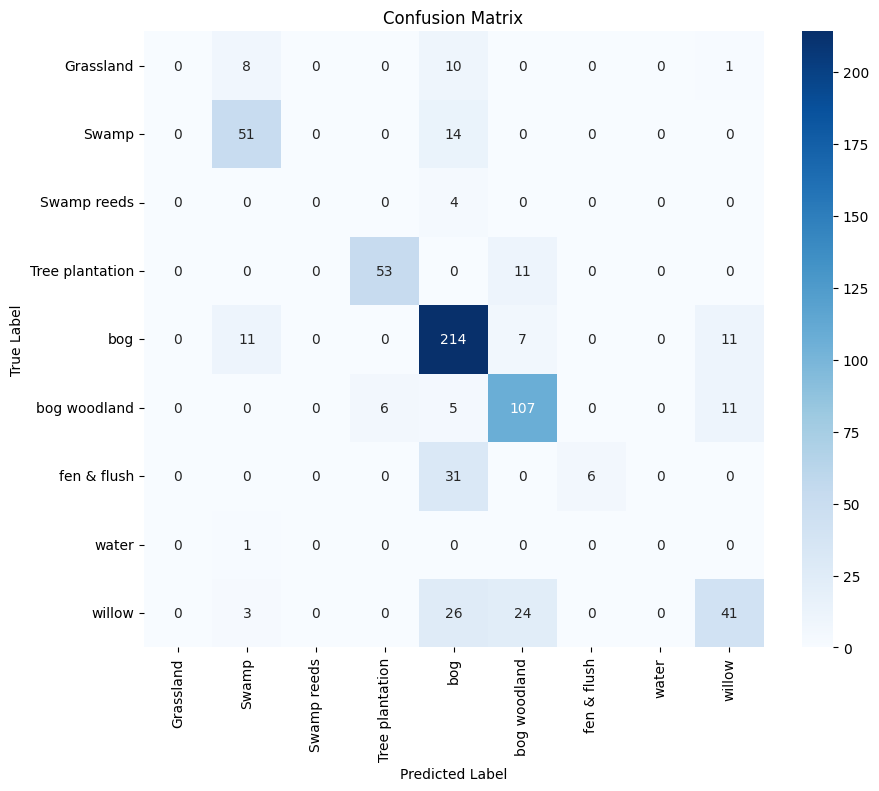

In [70]:
cm = confusion_matrix(y, y_pred, labels=np.unique(y))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [71]:
import numpy as np

def get_optimized_features(win_data, res):
    """
    Calculates 18 features for wetland classification.
    Features 1-16 follow the user-defined list.
    Features 17-18 add texture to resolve confusion matrix errors.
    """
    eps = 1e-7

    # 1-3. Summer RGB (Means)
    s_rgb = np.nanmean(win_data['s_rgb'], axis=(1, 2)).astype('float64')
    # 4-6. Winter RGB (Means)
    w_rgb = np.nanmean(win_data['w_rgb'], axis=(1, 2)).astype('float64')

    # 7-8. NDVI (Means)
    s_nd = np.clip(np.nanmean(win_data['s_ndvi']), -0.9, 0.9)
    w_nd = np.clip(np.nanmean(win_data['w_ndvi']), -0.9, 0.9)

    # 9-10. VARI (Visible Atmospheric Resistant Index)
    # Formula: (Green - Red) / (Green + Red - Blue)
    def calc_vari(rgb):
        r, g, b = rgb[0], rgb[1], rgb[2]
        return (g - r) / (g + r - b + eps)

    s_vari = np.clip(calc_vari(s_rgb), -10, 10)
    w_vari = np.clip(calc_vari(w_rgb), -10, 10)

    # 12-13. DSM Height (Means)
    s_h = np.nanmean(win_data['s_dsm'])
    w_h = np.nanmean(win_data['w_dsm'])

    # 15-16. Slopes
    def get_slope(dsm_data):
        dz_dy, dz_dx = np.gradient(dsm_data.astype('float64'), res)
        return np.nanmean(np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))))

    s_slope = get_slope(win_data['s_dsm'])
    w_slope = get_slope(win_data['w_dsm'])

    # 17-18. Texture (Standard Deviation of Green Band)
    # Critical for distinguishing smooth Water/Grass from rough Bog/Willow
    s_std = np.nanstd(win_data['s_rgb'][1])
    w_std = np.nanstd(win_data['w_rgb'][1])

    # Final Feature Stack
    features = np.concatenate([
        s_rgb,                 # 1-3
        w_rgb,                 # 4-6
        [s_nd, w_nd],          # 7-8
        [s_vari, w_vari],      # 9-10
        [s_nd - w_nd],         # 11: Delta NDVI
        [s_h, w_h],            # 12-13: Heights
        [s_h - w_h],           # 14: Delta Height
        [s_slope, w_slope],    # 15-16: Slopes
        [s_std, w_std]         # 17-18: Texture (Internal variance)
    ])

    return np.nan_to_num(features).astype('float32')

Starting Cross-Validation...
Training final model on the entire dataset for feature importances...
Final model training complete!

--- Classification Report ---
                 precision    recall  f1-score   support

      Grassland       0.38      0.26      0.31        19
          Swamp       0.68      0.63      0.66        65
    Swamp reeds       0.00      0.00      0.00         4
Tree plantation       0.89      0.84      0.86        64
            bog       0.77      0.87      0.81       243
   bog woodland       0.74      0.82      0.78       129
    fen & flush       0.78      0.57      0.66        37
          water       0.00      0.00      0.00         1
         willow       0.66      0.53      0.59        94

       accuracy                           0.74       656
      macro avg       0.54      0.50      0.52       656
   weighted avg       0.73      0.74      0.73       656



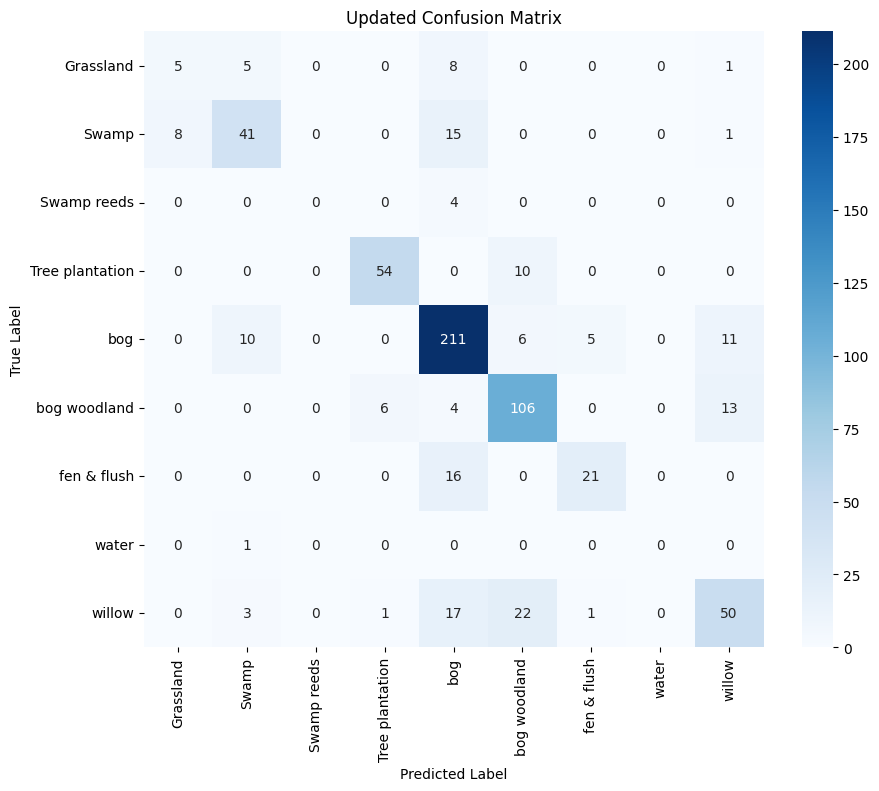

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Assuming X contains the features extracted above and y contains your labels
# X_scaled = scaler.fit_transform(X)

# Optimized Random Forest for Imbalanced Wetland Classes
rf = RandomForestClassifier(
    n_estimators=1000,           # More trees help stabilize minority class predictions
    max_features='sqrt',         # Randomly selects ~4 features per split
    max_depth=None,              # Allow trees to grow fully to find narrow minority class rules
    min_samples_leaf=1,          # Standard for RF, but can be increased if overfitting
    n_jobs=-1,                   # Use all CPU cores
    class_weight='balanced_subsample', # Weights classes per tree bootstrap (best for imbalance)
    random_state=42
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Starting Cross-Validation...")
# Using cross_val_predict to generate the data for the Confusion Matrix
y_pred = cross_val_predict(rf, X_scaled, y, cv=kf)

# Fit the model to the entire dataset after cross-validation for feature importances
print("Training final model on the entire dataset for feature importances...")
rf.fit(X_scaled, y)
print("Final model training complete!")

# 3. Final Reports
print("\n--- Classification Report ---")
print(classification_report(y, y_pred))

# To visualize the new Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Updated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = [
    'S_Red', 'S_Green', 'S_Blue',             # 1-3
    'W_Red', 'W_Green', 'W_Blue',             # 4-6
    'S_NDVI', 'W_NDVI',                       # 7-8
    'S_VARI', 'W_VARI',                       # 9-10
    'Delta_NDVI',                             # 11
    'S_Height', 'W_Height',                   # 12-13
    'Delta_Height',                           # 14
    'S_Slope', 'W_Slope',                     # 15-16
    'S_Texture', 'W_Texture'                  # 17-18
]

# Get feature importances from the trained model
importances = rf.feature_importances_

# Create a pandas Series for easier plotting
feat_importances = pd.Series(importances, index=feature_names)

# Sort the importances for better visualization
feat_importances = feat_importances.sort_values(ascending=True)

# Plotting
plt.figure(figsize=(10, 8))
feat_importances.plot(kind='barh')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

ValueError: Length of values (16) does not match length of index (18)

In [76]:
# 1. Clear the old lists and re-extract features using the 18-feature function
X_list_18, y_list_18 = [], []

with rasterio.open(W_NDVI_PATH) as master:
    master_transform = master.transform
    master_crs = master.crs

gdf = gpd.read_file(SHP_PATH).to_crs(master_crs)
gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd, rasterio.open(W_RGB_PATH) as wr, \
     rasterio.open(W_NDVI_PATH) as wn, rasterio.open(W_DSM) as wd:

    print(f"Re-extracting features using KERNEL={KERNEL} (20m x 20m) with 18 features...")

    for _, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        geom = row.geometry
        poly_window = rasterio.windows.from_bounds(*geom.bounds, transform=wn.transform)
        poly_window = poly_window.round_offsets().round_shape()

        p_rows, p_cols = int(poly_window.height), int(poly_window.width)
        if p_rows < KERNEL or p_cols < KERNEL: continue

        try:
            data_full = {
                's_rgb': sr.read(window=poly_window, out_shape=(3, p_rows, p_cols)),
                's_ndvi':  sn.read(1, window=poly_window, out_shape=(p_rows, p_cols)),
                's_dsm': sd.read(1, window=poly_window, out_shape=(p_rows, p_cols)),
                'w_rgb': wr.read(window=poly_window, out_shape=(3, p_rows, p_cols)),
                'w_ndvi':  wn.read(1, window=poly_window, out_shape=(p_rows, p_cols)),
                'w_dsm': wd.read(1, window=poly_window, out_shape=(p_rows, p_cols))
            }
        except: continue

        chunk_transform = rasterio.windows.transform(poly_window, wn.transform)

        for r in range(0, p_rows - KERNEL, KERNEL):
            for c in range(0, p_cols - KERNEL, KERNEL):
                center_coords = chunk_transform * (c + KERNEL//2, r + KERNEL//2)
                if Point(center_coords).within(geom):
                    patch = {
                        's_rgb': data_full['s_rgb'][:, r:r+KERNEL, c:c+KERNEL],
                        's_ndvi': data_full['s_ndvi'][r:r+KERNEL, c:c+KERNEL],
                        's_dsm': data_full['s_dsm'][r:r+KERNEL, c:c+KERNEL],
                        'w_rgb': data_full['w_rgb'][:, r:r+KERNEL, c:c+KERNEL],
                        'w_ndvi': data_full['w_ndvi'][r:r+KERNEL, c:c+KERNEL],
                        'w_dsm': data_full['w_dsm'][r:r+KERNEL, c:c+KERNEL]
                    }
                    X_list_18.append(get_optimized_features(patch, TARGET_RES)) # Use the 18-feature function
                    y_list_18.append(row['merged_name'])

X = np.array(X_list_18)
y = np.array(y_list_18)
print(f"Extraction complete: {len(X)} objects with {X.shape[1]} features.")

Re-extracting features using KERNEL=304 (20m x 20m) with 18 features...


100%|██████████| 18/18 [00:43<00:00,  2.42s/it]

Extraction complete: 656 objects with 18 features.


In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.nan_to_num(X))

Starting Cross-Validation...
Training final model on the entire dataset for feature importances...
Final model training complete!

--- Classification Report ---
                 precision    recall  f1-score   support

      Grassland       0.47      0.37      0.41        19
          Swamp       0.68      0.62      0.65        65
    Swamp reeds       0.00      0.00      0.00         4
Tree plantation       0.88      0.83      0.85        64
            bog       0.77      0.88      0.82       243
   bog woodland       0.73      0.82      0.77       129
    fen & flush       0.79      0.51      0.62        37
          water       0.00      0.00      0.00         1
         willow       0.64      0.53      0.58        94

       accuracy                           0.74       656
      macro avg       0.55      0.51      0.52       656
   weighted avg       0.73      0.74      0.73       656



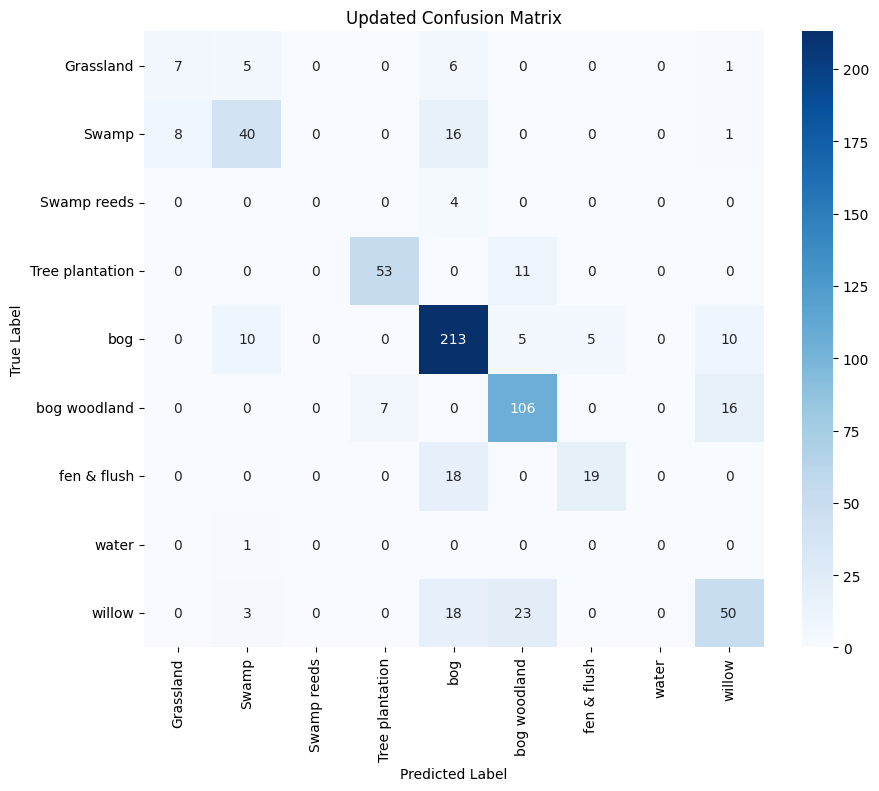

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Assuming X contains the features extracted above and y contains your labels
# X_scaled = scaler.fit_transform(X)

# Optimized Random Forest for Imbalanced Wetland Classes
rf = RandomForestClassifier(
    n_estimators=1000,           # More trees help stabilize minority class predictions
    max_features='sqrt',         # Randomly selects ~4 features per split
    max_depth=None,              # Allow trees to grow fully to find narrow minority class rules
    min_samples_leaf=1,          # Standard for RF, but can be increased if overfitting
    n_jobs=-1,                   # Use all CPU cores
    class_weight='balanced_subsample', # Weights classes per tree bootstrap (best for imbalance)
    random_state=42
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Starting Cross-Validation...")
# Using cross_val_predict to generate the data for the Confusion Matrix
y_pred = cross_val_predict(rf, X_scaled, y, cv=kf)

# Fit the model to the entire dataset after cross-validation for feature importances
print("Training final model on the entire dataset for feature importances...")
rf.fit(X_scaled, y)
print("Final model training complete!")

# 3. Final Reports
print("\n--- Classification Report ---")
print(classification_report(y, y_pred))

# To visualize the new Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Updated Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

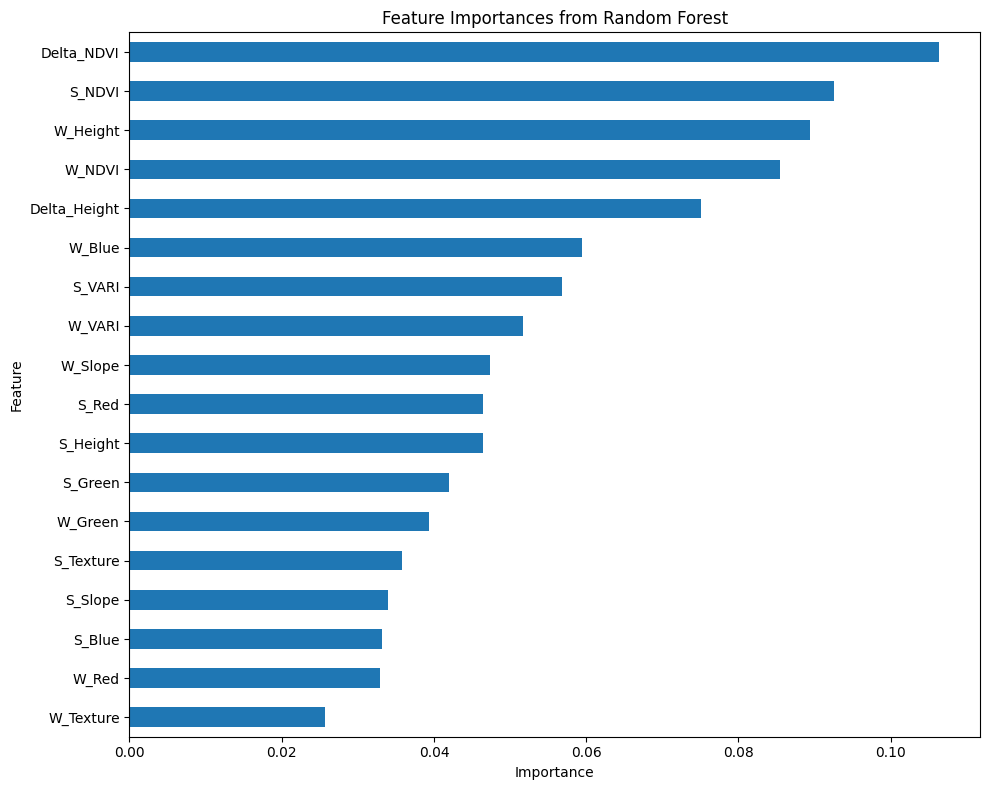

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = [
    'S_Red', 'S_Green', 'S_Blue',             # 1-3
    'W_Red', 'W_Green', 'W_Blue',             # 4-6
    'S_NDVI', 'W_NDVI',                       # 7-8
    'S_VARI', 'W_VARI',                       # 9-10
    'Delta_NDVI',                             # 11
    'S_Height', 'W_Height',                   # 12-13
    'Delta_Height',                           # 14
    'S_Slope', 'W_Slope',                     # 15-16
    'S_Texture', 'W_Texture'                  # 17-18
]

# Get feature importances from the trained model
importances = rf.feature_importances_

# Create a pandas Series for easier plotting
feat_importances = pd.Series(importances, index=feature_names)

# Sort the importances for better visualization
feat_importances = feat_importances.sort_values(ascending=True)

# Plotting
plt.figure(figsize=(10, 8))
feat_importances.plot(kind='barh')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [83]:
unique_classes = np.unique(y)
per_class_importances = {}

print("Calculating per-class feature importances using One-vs-Rest strategy...")

for target_class in unique_classes:
    print(f"\nTraining model for class: {target_class}")

    # Create binary labels: 1 for target_class, 0 for all other classes
    y_binary = (y == target_class).astype(int)

    # Create a balanced Random Forest classifier for the binary problem
    # Using similar parameters as the global model for consistency
    rf_binary = RandomForestClassifier(
        n_estimators=1000,
        max_features='sqrt',
        max_depth=None,
        min_samples_leaf=1,
        n_jobs=-1,
        class_weight='balanced_subsample', # Important for imbalanced binary problems
        random_state=42
    )

    # Train the binary classifier on the scaled data
    rf_binary.fit(X_scaled, y_binary)

    # Store the feature importances for this specific class
    per_class_importances[target_class] = rf_binary.feature_importances_

print("Per-class feature importances calculation complete.")

Calculating per-class feature importances using One-vs-Rest strategy...

Training model for class: Grassland

Training model for class: Swamp

Training model for class: Swamp reeds

Training model for class: Tree plantation

Training model for class: bog

Training model for class: bog woodland

Training model for class: fen & flush

Training model for class: water

Training model for class: willow
Per-class feature importances calculation complete.


**Reasoning**:
To visualize the per-class feature importances, I will iterate through the `per_class_importances` dictionary, create a pandas Series for each class's importances with corresponding feature names, sort them, and then plot a horizontal bar chart for each class.



Displaying per-class feature importances...


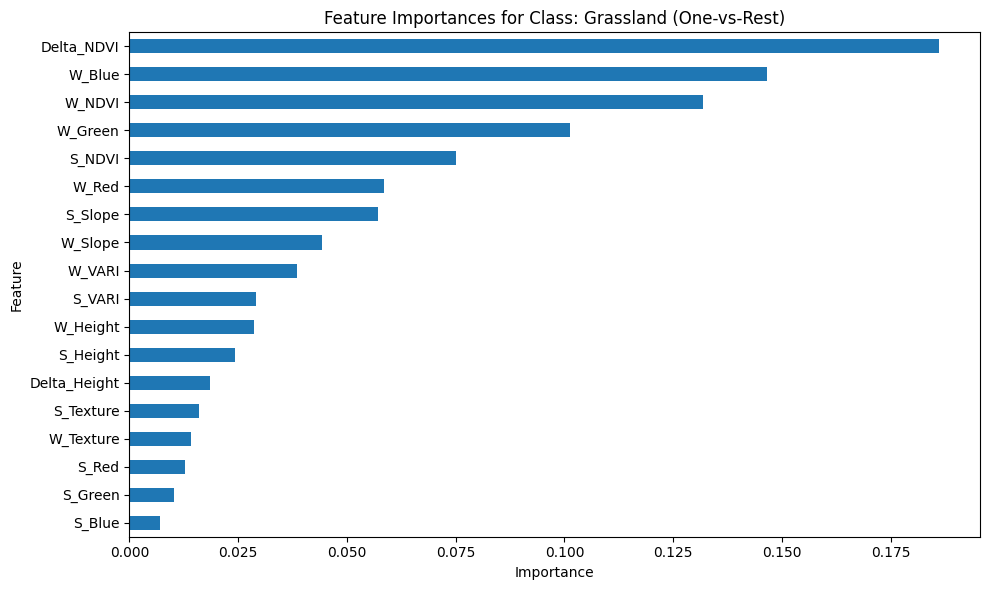

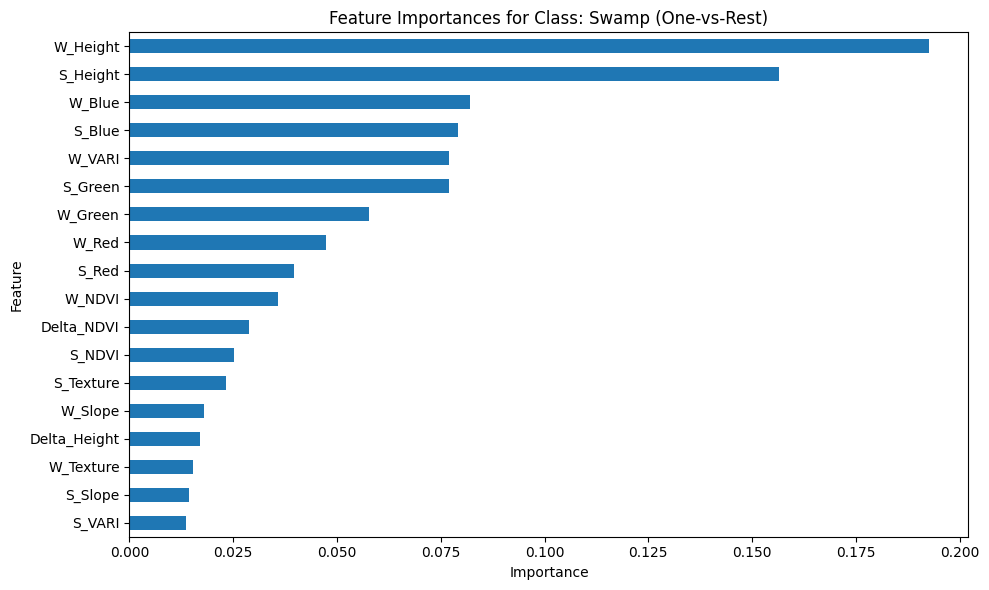

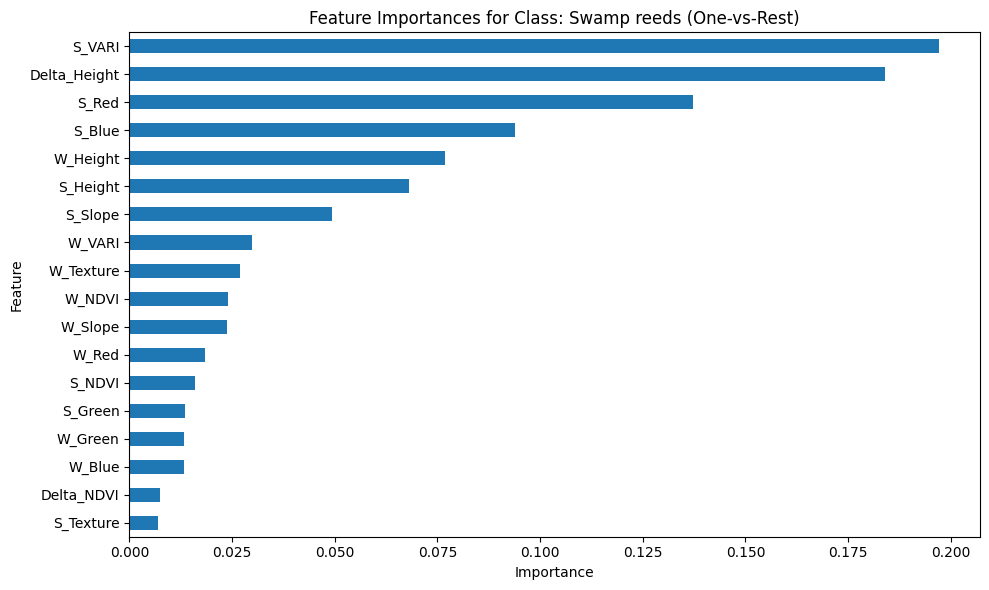

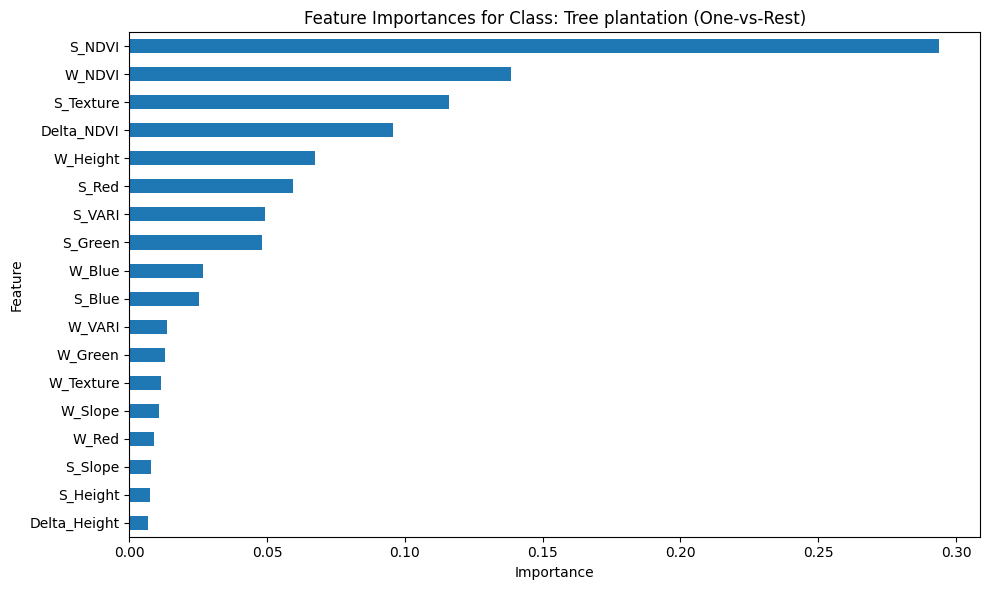

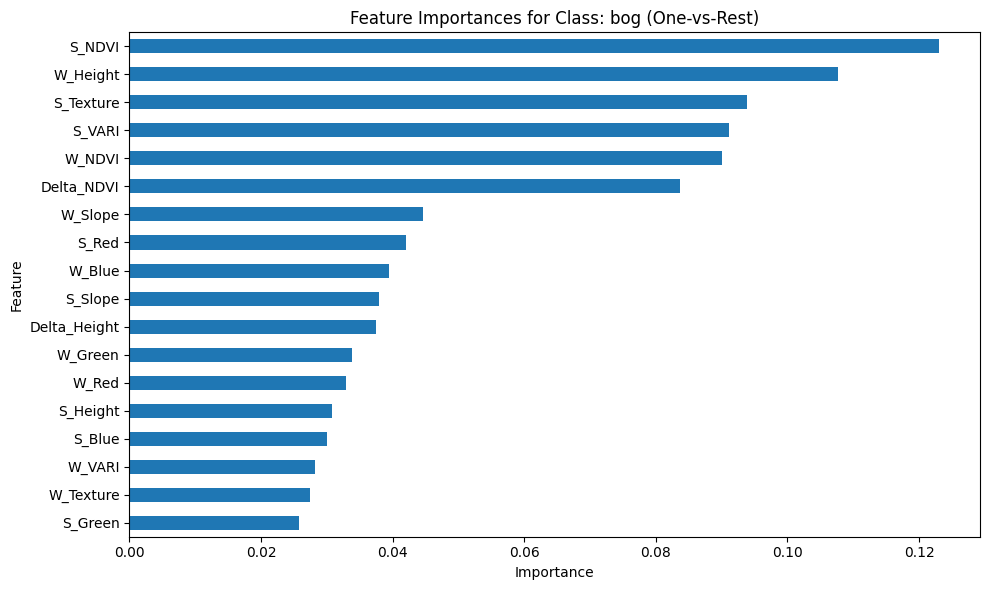

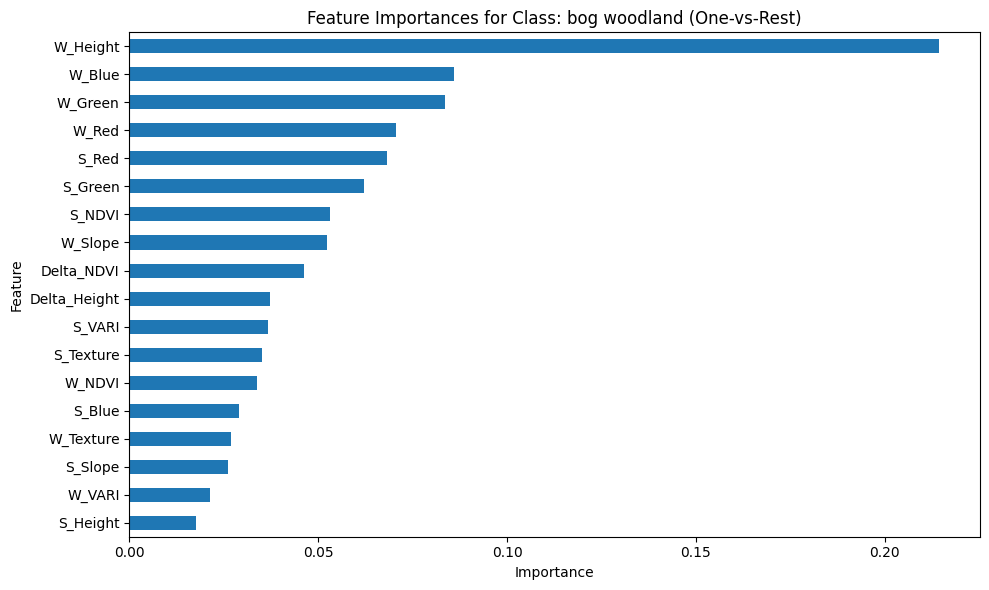

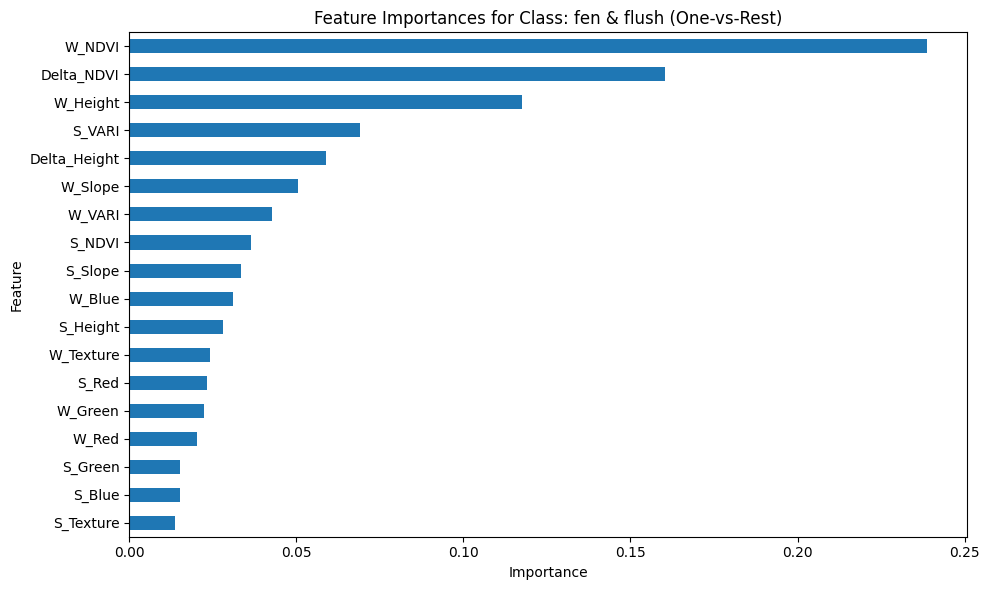

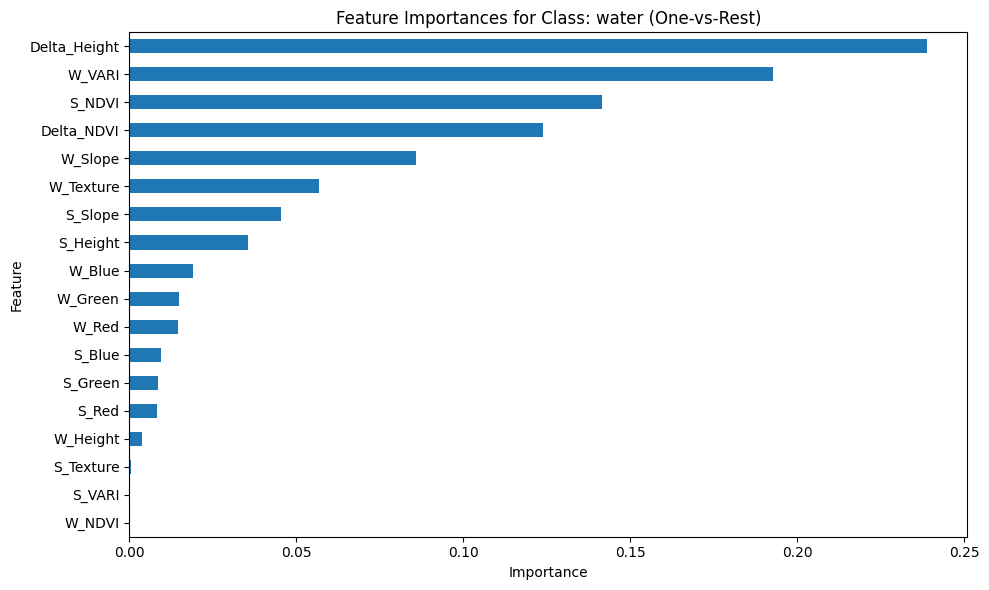

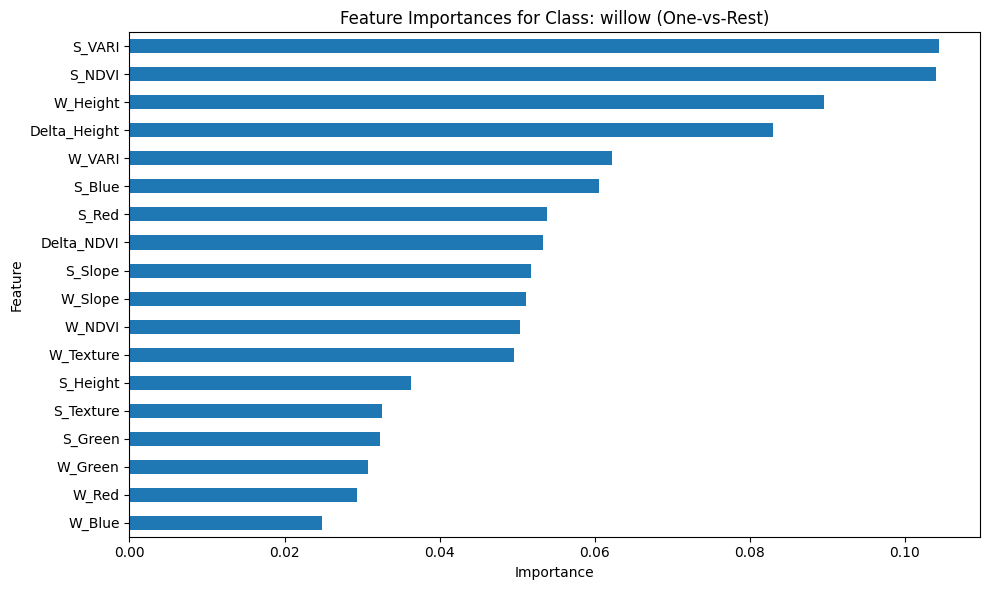

In [84]:
import matplotlib.pyplot as plt
import pandas as pd

# Define feature names (must match the length of importances array)
feature_names = [
    'S_Red', 'S_Green', 'S_Blue',             # 1-3
    'W_Red', 'W_Green', 'W_Blue',             # 4-6
    'S_NDVI', 'W_NDVI',                       # 7-8
    'S_VARI', 'W_VARI',                       # 9-10
    'Delta_NDVI',                             # 11
    'S_Height', 'W_Height',                   # 12-13
    'Delta_Height',                           # 14
    'S_Slope', 'W_Slope',                     # 15-16
    'S_Texture', 'W_Texture'                  # 17-18
]

print("Displaying per-class feature importances...")

for class_name, importances in per_class_importances.items():
    # Ensure the feature_names list matches the length of the importances array
    if len(importances) != len(feature_names):
        print(f"Warning: Feature importance length ({len(importances)}) does not match feature_names length ({len(feature_names)}) for class {class_name}.")
        continue

    feat_importances = pd.Series(importances, index=feature_names)
    feat_importances = feat_importances.sort_values(ascending=True)

    plt.figure(figsize=(10, 6))
    feat_importances.plot(kind='barh')
    plt.title(f'Feature Importances for Class: {class_name} (One-vs-Rest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


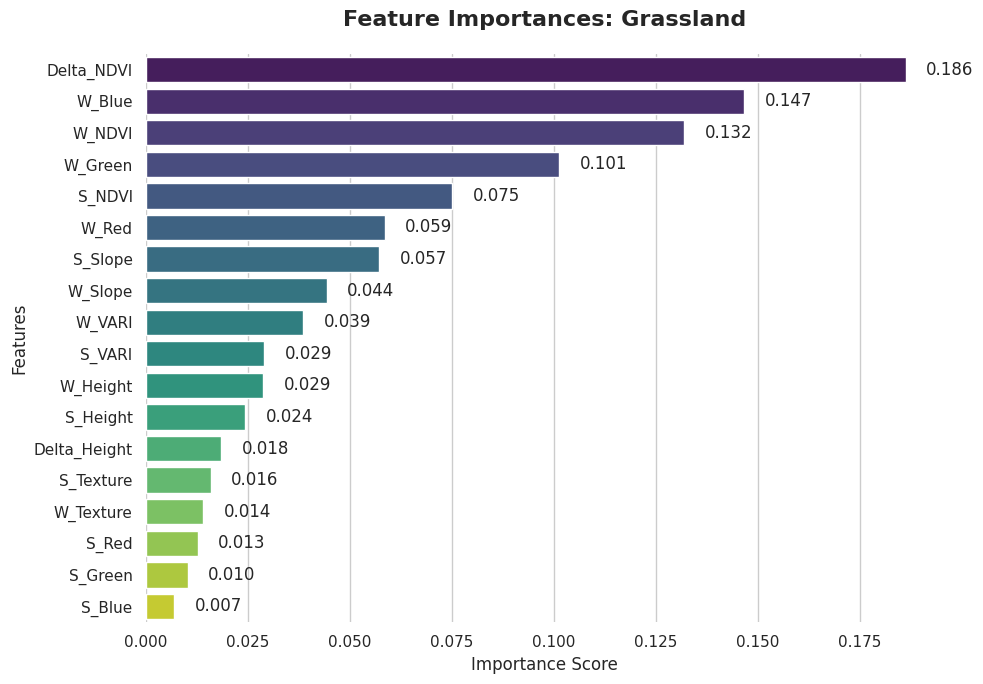

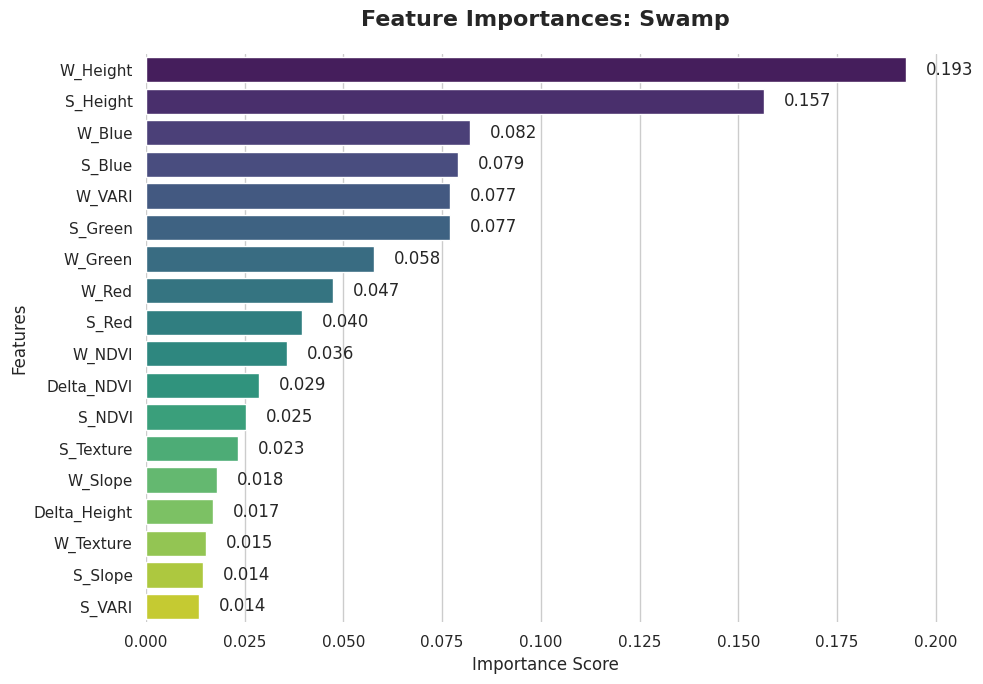

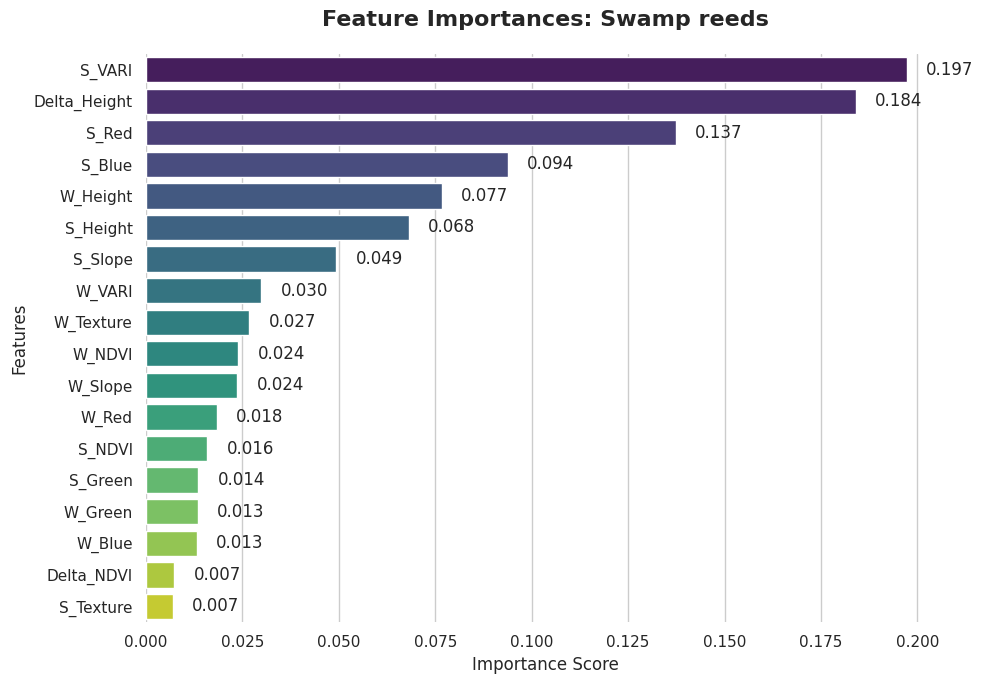

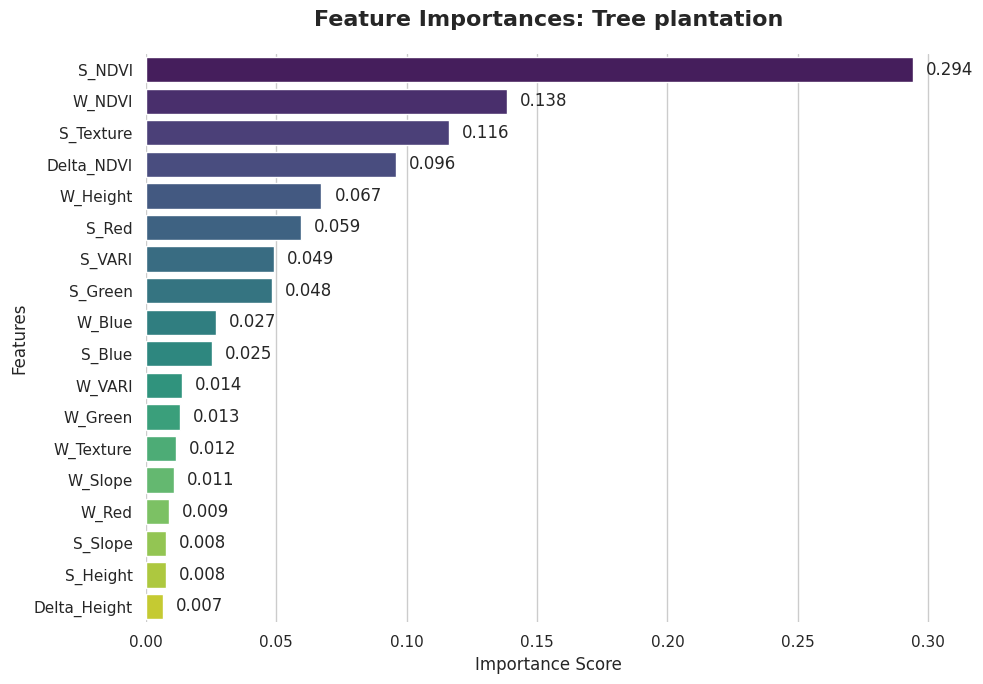

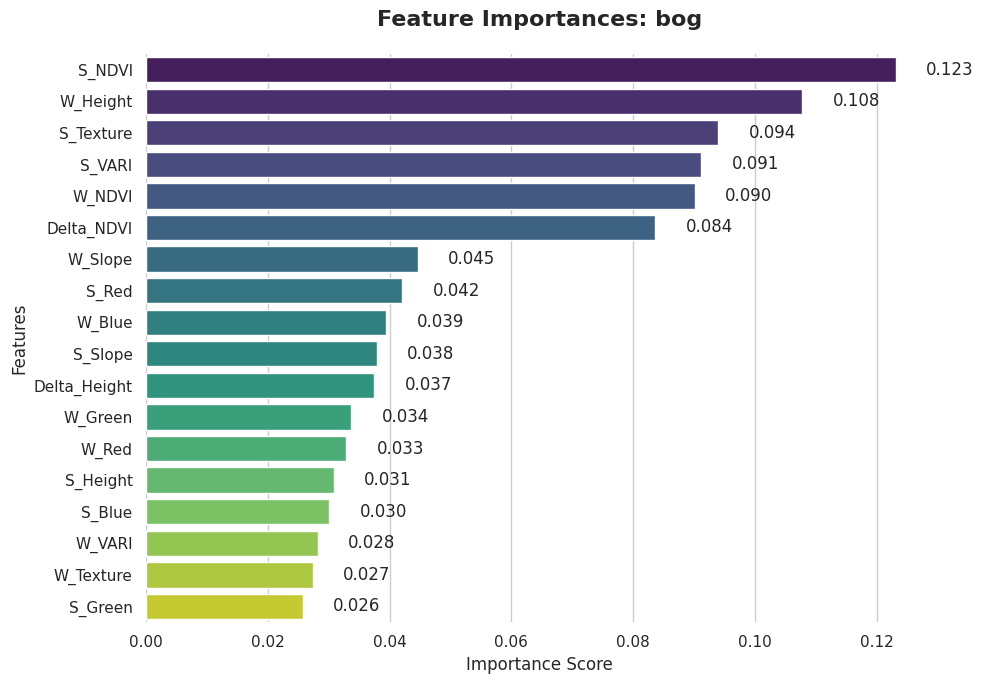

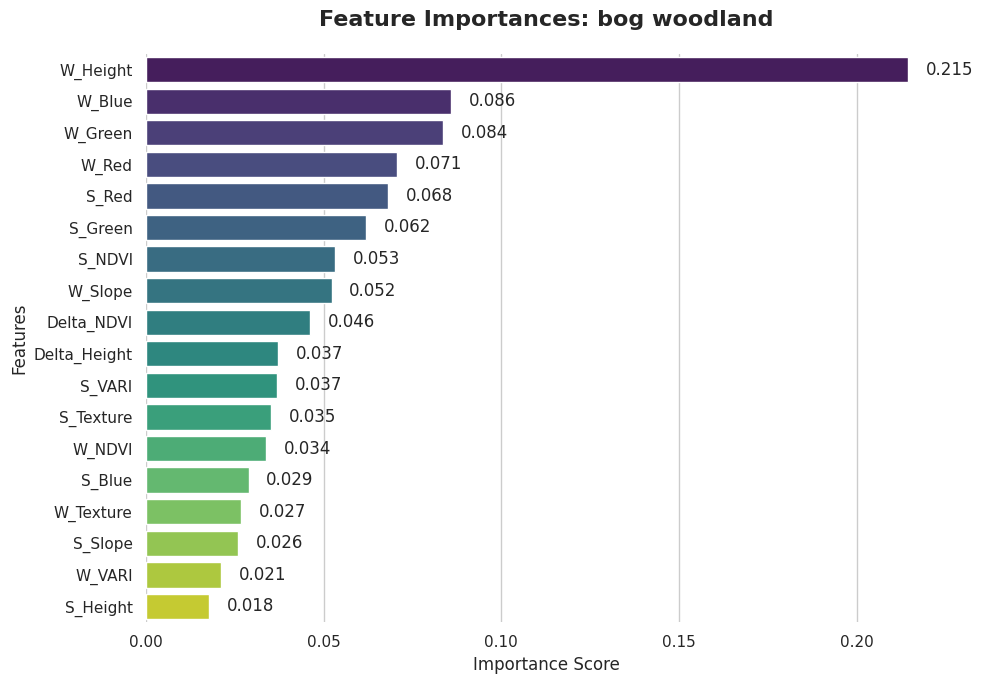

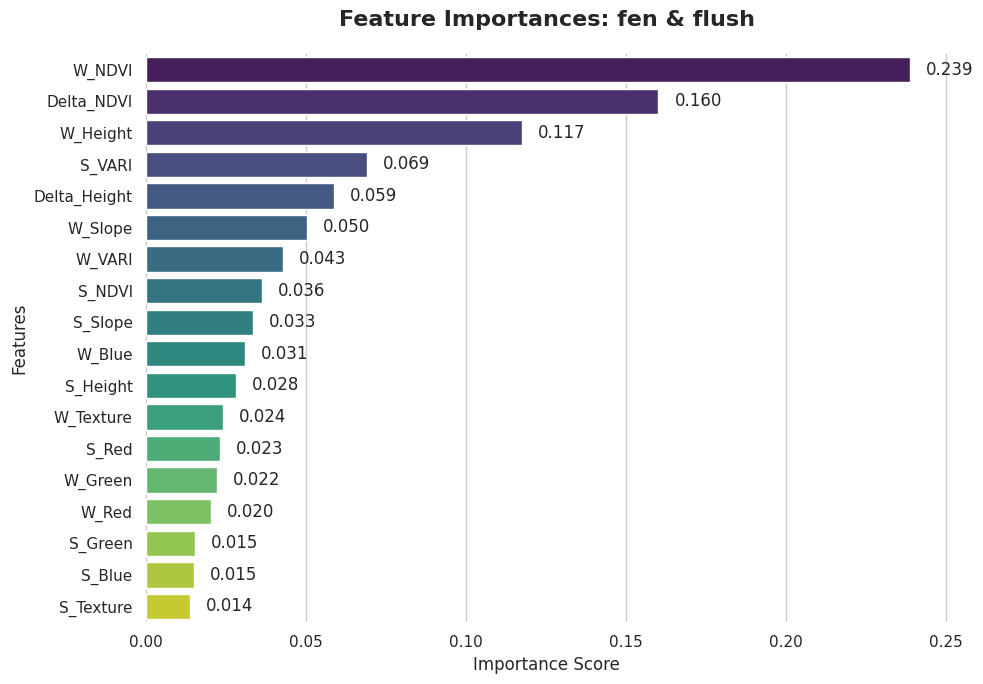

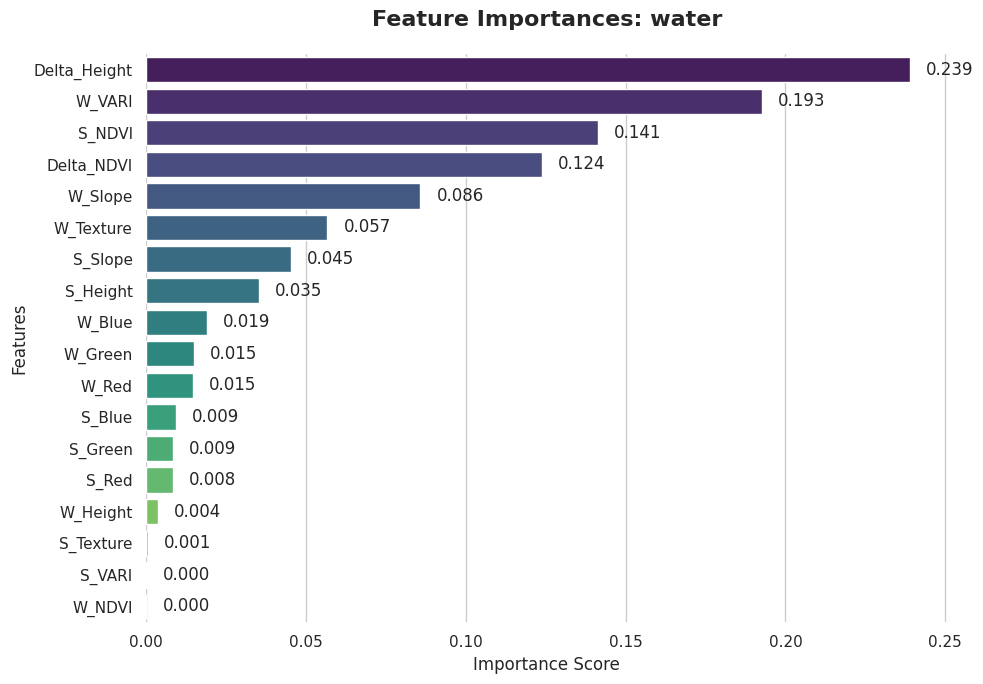

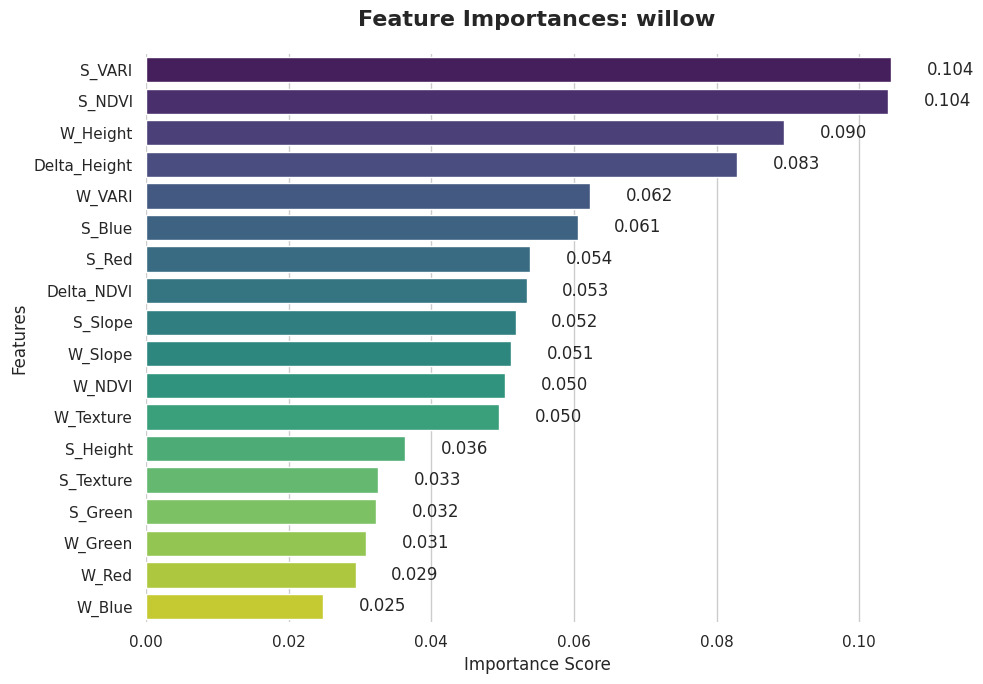

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set a cleaner style
sns.set_theme(style="whitegrid")

for class_name, importances in per_class_importances.items():
    if len(importances) != len(feature_names):
        print(f"Warning: Length mismatch for class {class_name}.")
        continue

    # Create a DataFrame for easier plotting with Seaborn
    df_plot = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 7))

    # Use a color gradient (viridis, rocket, or mako)
    ax = sns.barplot(
        x='Importance',
        y='Feature',
        data=df_plot,
        palette='viridis',
        hue='Feature', # Added to avoid future warnings
        legend=False
    )

    # Add data labels to the end of each bar
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 0.005, p.get_y() + p.get_height()/2,
                 f'{width:.3f}',
                 va='center')

    plt.title(f'Feature Importances: {class_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)

    # Despine to make it look modern
    sns.despine(left=True, bottom=True)

    plt.tight_layout()
    plt.show()

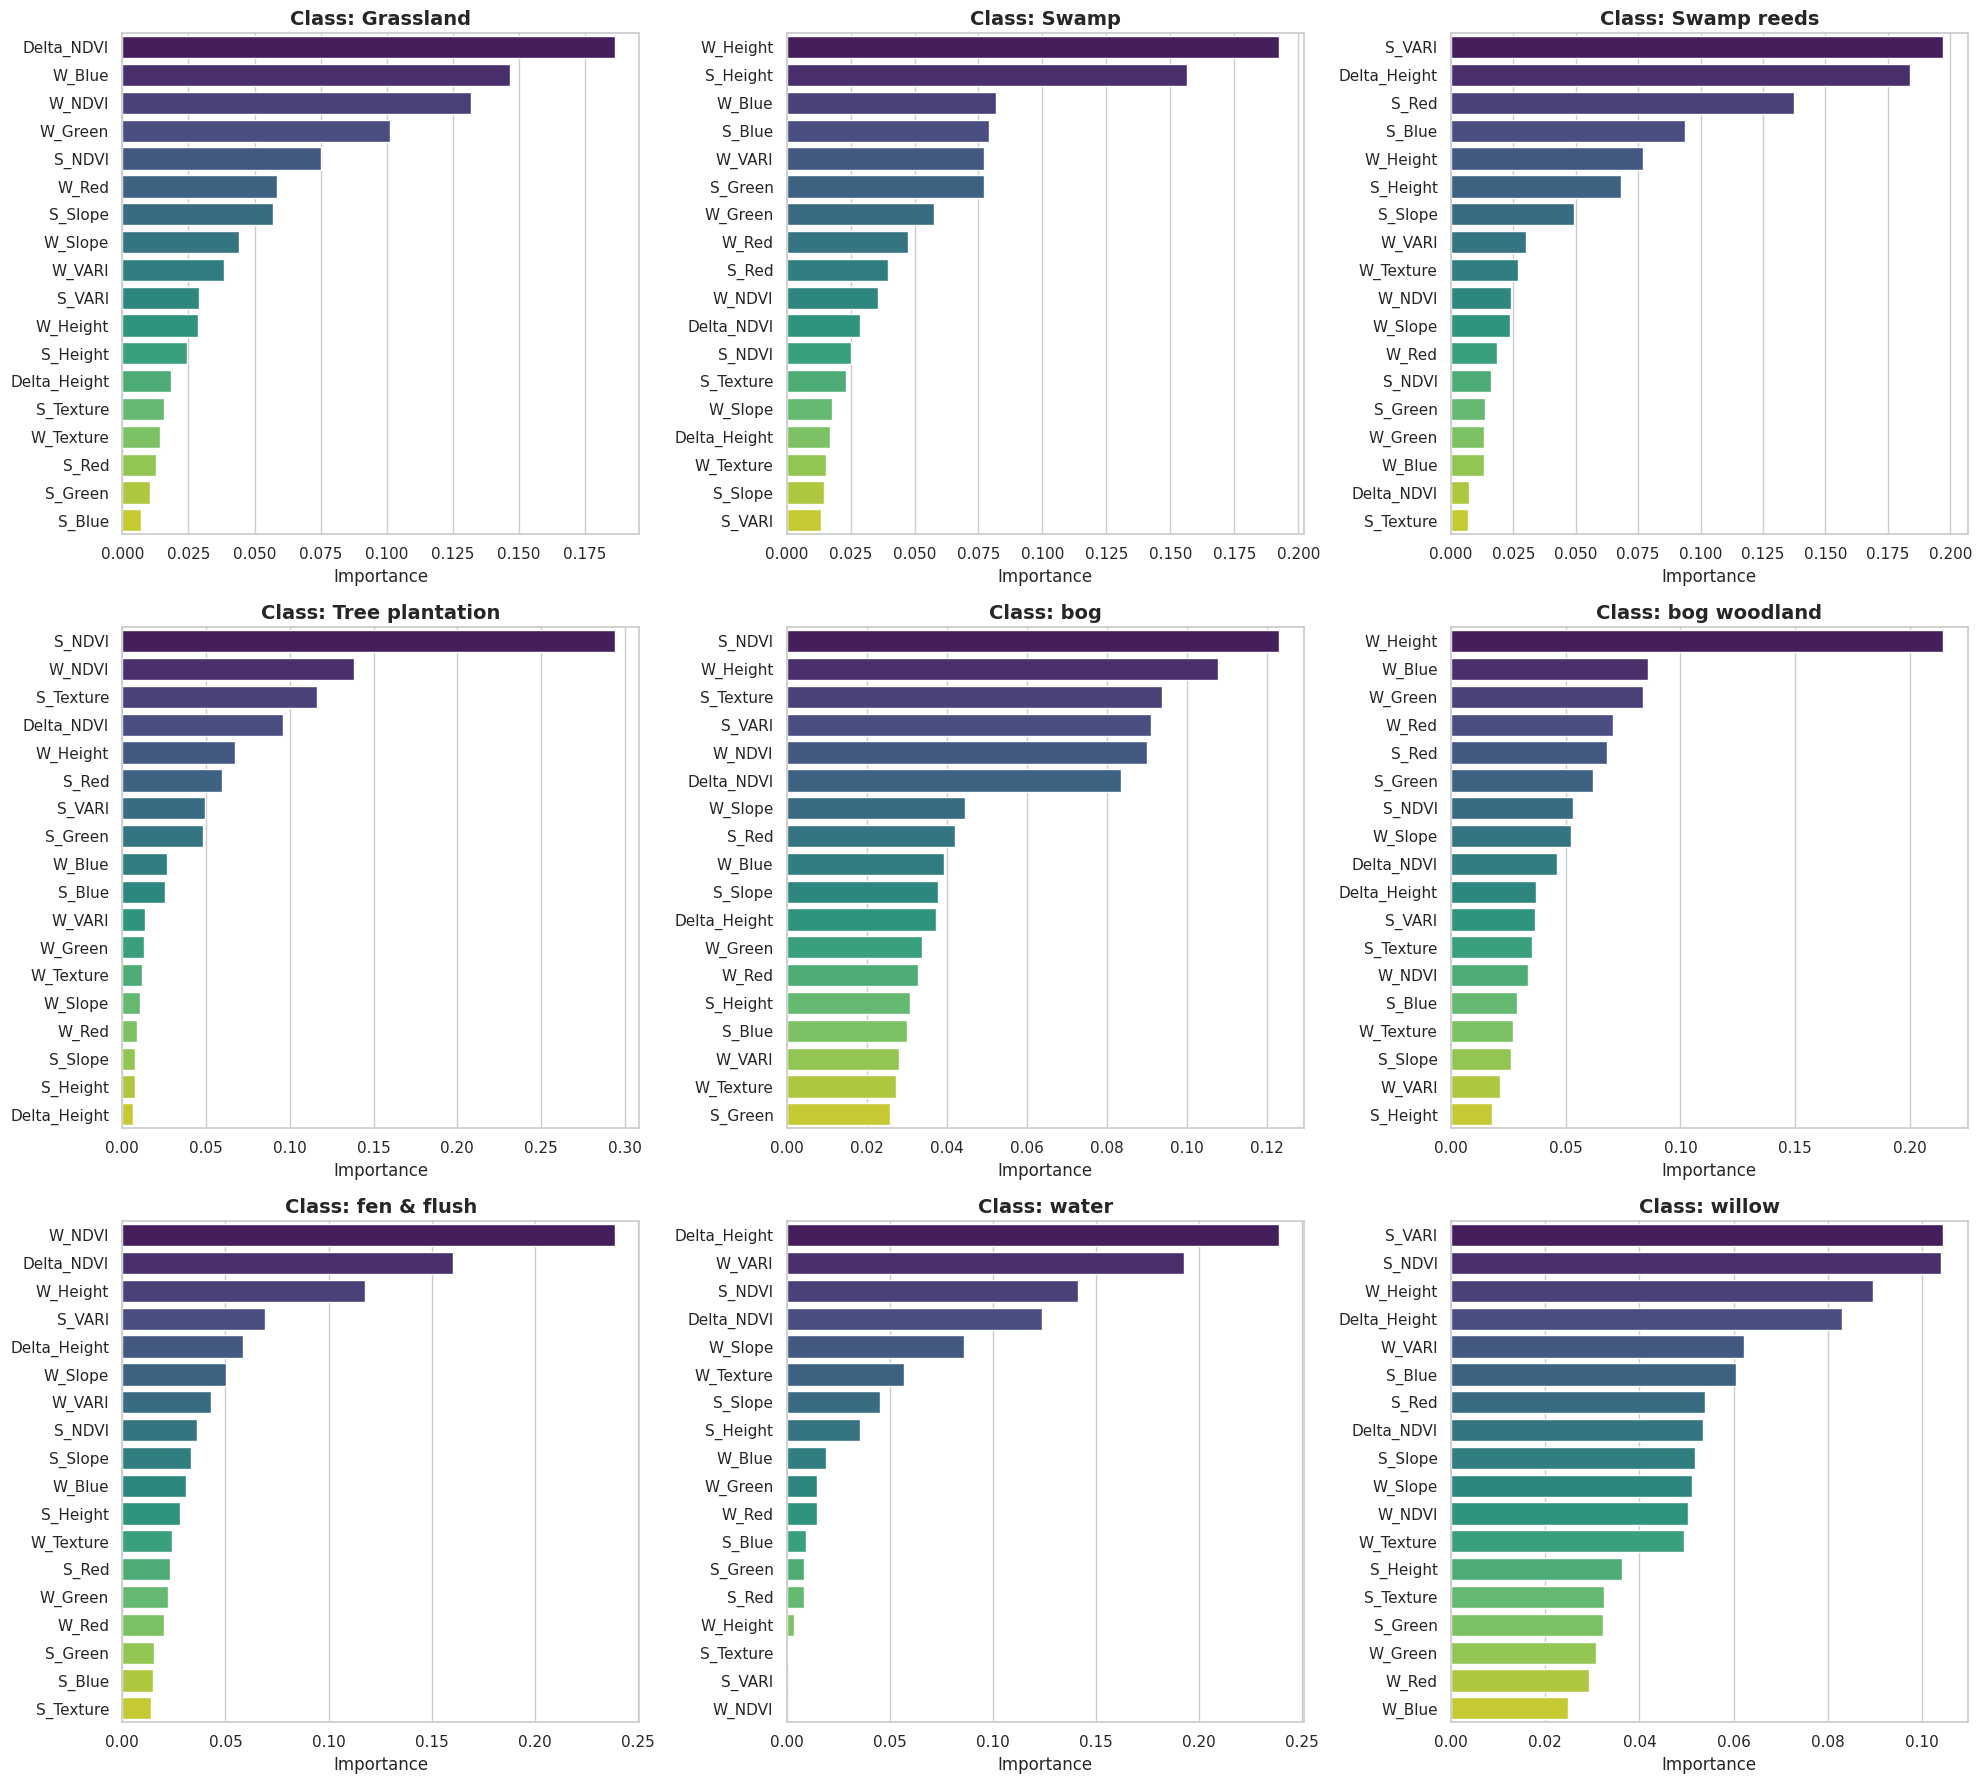

In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

# Set style
sns.set_theme(style="whitegrid")

# Convert dictionary items to a list for easier indexing
class_items = list(per_class_importances.items())
num_classes = len(class_items)
cols = 3
rows = math.ceil(num_classes / cols)

# Create the figure
fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))
axes = axes.flatten() # Flatten to 1D array for easy iteration

for i in range(len(axes)):
    if i < num_classes:
        class_name, importances = class_items[i]

        # Prepare Data
        df_plot = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        # Plot on the specific subplot axis (axes[i])
        sns.barplot(
            x='Importance',
            y='Feature',
            data=df_plot,
            palette='viridis',
            ax=axes[i],
            hue='Feature',
            legend=False
        )

        axes[i].set_title(f'Class: {class_name}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Importance')
        axes[i].set_ylabel('') # Clear y-label for cleaner look

    else:
        # Hide empty subplots if num_classes is not a multiple of 3
        axes[i].axis('off')

plt.tight_layout()
plt.show()